<a href="https://colab.research.google.com/github/PrazaKembaren/AnDaSat-Tugas-1/blob/main/%5BAK3031%5D_Analisis_Data_Satelit_Mengolah_Data_Kecerlangan_Langit_dengan_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tugas Mengolah Data Kecerlangan Langit dengan GEE


Dari https://colab.research.google.com/github/NLTGit/OpenNightLights-colab-mirror/blob/master/onl/tutorials/mod3_2_image_clipping_with_VIIRS.ipynb


Di sini kita akan berlatih menggunakan GEE untuk mendapat data kecerlangan langit untuk provinsi di Indonesia.

Masing-masing orang silakan pilih provinsi di
GAUL (Global Administrative Unit Layers Level 1)

https://data.apps.fao.org/catalog/dataset/global-administrative-unit-layers-gaul/resource/ebf408a0-fa81-4fdf-9c51-ced6737db0fe


Dan tulis di sini
https://docs.google.com/spreadsheets/d/1g76HZHQWEp_u3Yyo0LaDPQjEJlS61s5lGOV9L74_Fe0/edit?usp=sharing

Karena di GAUL hanya ada provinsi lama, yang memilih provinsi baru, silakan mengganti menjadi negara tetangga Indonesia seperti Timor Leste, Singapura, atau Malaysia.

Pada latihan ini:
- mengambil data VIIRS komposit, klip ke geometri. Hitung rata-rata dan standar deviasi nilai VIIRS komposit

- Cari data statistik dari BPS untuk setiap provinsi

- Buat grafik sederhana


Pertama, install GEE (Google Earth Engine)

##Pra-proses Pengolahan Data

In [ ]:
!pip install geemap #install modul

In [ ]:
# import GEEmaP
import geemap, ee
import numpy as np
from matplotlib import dates as mdates
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

#inisialisasi token GEE

##Get Data

Cari data VIIRS radiasi rerata VIIRS bulanan (misal Desember 2019)

###Data

In [ ]:
# get December image, we're using the "avg_rad" band
viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2019-12-01","2019-12-31").select('avg_rad').median()

###Mapping

In [ ]:
# inisialisasi peta
map1 = geemap.Map()
map1.add_basemap('SATELLITE')
map1.addLayer(viirs2019_12, {}, "VIIRS-DNB Dec 2019")

map1.addLayerControl()
map1

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Lakukan clipping Untuk Provinsi Sumatra Utara

Buat AOI (Area of Interest) dengan `ee.Geometry.Point` , masukkan provinsi

In [ ]:
viirs2017_121 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2019-12-01","2019-12-31").select('avg_rad').first()

# Cari geometri provinsi Sumatra Utara
peta1 = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Sumatera Utara')).first()).geometry()

# clip
petaclip1 = viirs2017_121.clip(peta1)


# Buat peta
map1 = geemap.Map()
map1.centerObject(peta1, zoom=8)
map1.add_basemap('SATELLITE')
map1.addLayer(petaclip1, {}, "VIIRS-DNB Dec 2019")
map1.addLayerControl()
map1

Map(center=[2.1919598430779526, 99.0557867180781], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
#geemap.ee_export_image(petaclip1, filename='sumut.tif', scale=10, region=peta1, file_per_band=True)

###Inisialisasi Interval range bulanan untuk pengambilan data

In [ ]:
name = '/content/tgl.txt'
data = open(name, 'r')
#tgl = pd.DataFrame(data)
dataload = data.readlines()
data.close()

###Pengambilan data untuk setiap range bulanan yang telah didefinisikan

In [ ]:
value = []

for line in dataload:
  newline = line.replace("\n", "")
  listline = newline.split(";")
  viirs2019_12 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(listline[0],listline[1]).select('avg_rad').first()

# Cari geometri provinsi
  peta = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Sumatera Utara')).first()).geometry()

  petaclip = viirs2019_12.clip(peta)

  mu = petaclip.reduceRegion(reducer=ee.Reducer.mean(), scale=500)

  munumber = ee.Number(mu.get('avg_rad'))

  value.append(munumber)




###Append data

In [ ]:
data = []
for k in value:
  v = ee.Number(k).getInfo()
  data.append(v)

In [ ]:
month = '/content/tgl.txt'
month = open(month, 'r')
mn = []
for line in dataload:
  newline = line.replace("\n", "")
  listline = newline.split(";")
  month = listline[0]
  mn.append(month)                     #query data pada satu kolom (untuk keperluan plotting)
month = pd.DataFrame(mn)

In [ ]:
data = pd.DataFrame(data)
data["F"] = data[0]
data["month"] = month[0]
data = data[["F", 'month']]

In [ ]:
data

,F,month
0,0.237962,2014-01-01
1,0.276092,2014-02-01
2,0.372926,2014-03-01
3,0.334248,2014-04-01
4,0.202870,2014-05-01
...,...,...
79,0.630321,2020-08-01
80,0.197042,2020-09-01
81,0.130088,2020-10-01
82,0.077266,2020-11-01


###Data Statistik Sumatra Utara  yakni IPM, Sumber Penerangan dari Listrik (%) dan Tenaga listrik yang dibangkitkan (GWh)

In [ ]:
ipm = pd.read_excel("/content/IPMsumut.xlsx")
ipm

,Tahun,IPM,GWh,persen
0,2014,68.87,18028.30,95.97
1,2015,69.51,18876.59,96.81
2,2016,70.00,0.00,96.84
3,2017,70.57,18544.99,97.41
4,2018,71.18,20188.10,97.55
5,2019,71.74,20764.57,98.37
6,2020,71.77,20667.17,98.72


<Axes: >

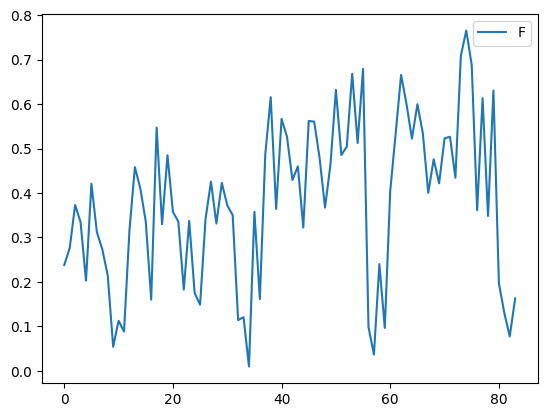

In [ ]:
F = data["F"]
data.plot() #plot bulan masih dalam integer

In [ ]:
import datetime
data['Tahun'] = data['month'] #karena data ridak dalam satu tahun, maka interval diubah dari Bulanan ke tahunan

In [ ]:
data['Tahun'] = pd.to_datetime(data['Tahun'], format = '%Y-%m-%d').dt.date
data.set_index('Tahun', inplace = True)


##Plotting

###Plot Kecerlangan Langit Bulanan Sumatra Utara

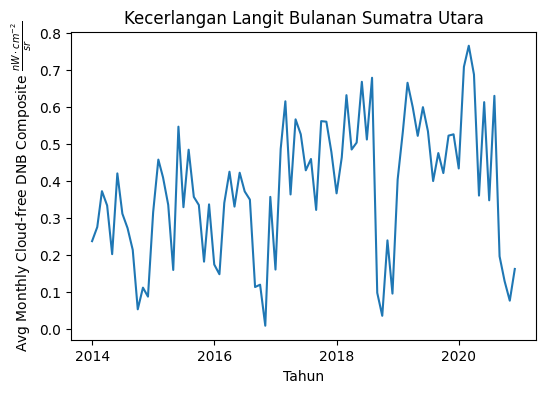

In [ ]:
#plt.plot(data['month'],data['F'])
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
data['F'].plot()
plt.title("Kecerlangan Langit Bulanan Sumatra Utara")
plt.ylabel(r'Avg Monthly Cloud-free DNB Composite $\frac{nW \cdot cm^{-2}}{sr}$')
step = 2
ax.xaxis.set_major_locator(md.YearLocator(step, month = 1, day = 1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))

###Plot Kecerlangan Langit Tahunan Sumatra Utara

Text(0, 0.5, 'Avg Yearly Cloud-free DNB Composite $\\frac{nW \\cdot cm^{-2}}{sr}$')

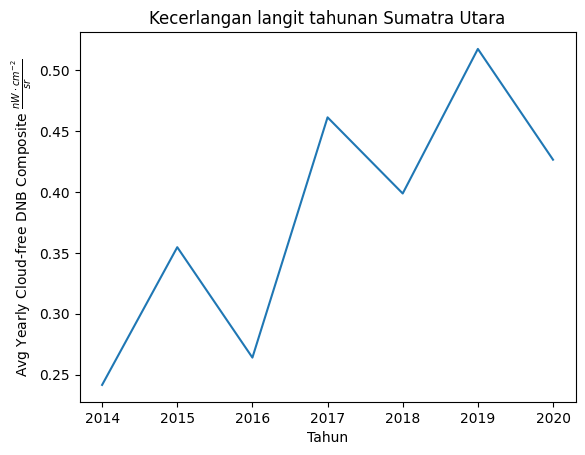

In [ ]:
dF = data['F'].values
avgF = np.average(dF.reshape(-1, 12), axis=1)
dt = []
for i in range(len(avgF)):
  x = i+2014
  dt.append(x)

plt.plot(dt, avgF)
plt.plot(ipm['Tahun'][4:-3], ipm['IPM'][4:-3])
plt.title("Kecerlangan langit tahunan Sumatra Utara")
plt.xlabel("Tahun")
plt.ylabel(r"Avg Yearly Cloud-free DNB Composite $\frac{nW \cdot cm^{-2}}{sr}$")

In [ ]:
ipm['GWh'].replace(0, np.NaN, inplace=True)

ipm['GWh'] = ipm['GWh'].interpolate()

###Plot Kecerlangan Langit Tahunan Vs IPM Sumatra Utara

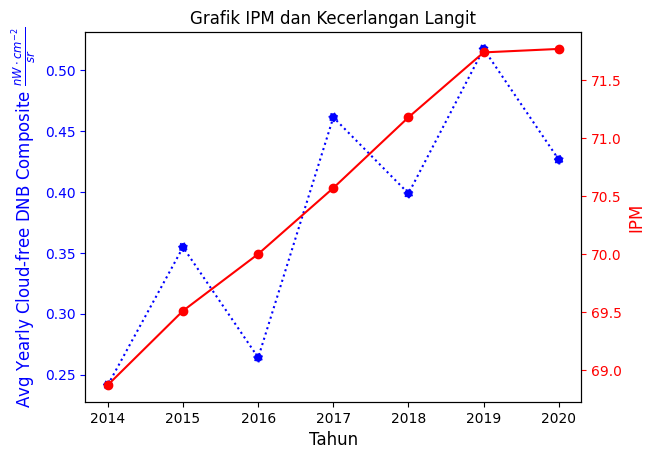

In [ ]:
#define subplots
fig,ax = plt.subplots()
plt.title("Grafik IPM dan Kecerlangan Langit")

#add first line to plot
ax.plot(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
ax.scatter(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
#add x-axis label
ax.set_xlabel('Tahun', fontsize=12)
#ax.legend()

#add y-axis label
ax.set_ylabel(r'Avg Yearly Cloud-free DNB Composite $\frac{nW \cdot cm^{-2}}{sr}$', color='b', fontsize=12)
#ax.tick_params(axis='x', colors="b")
ax.tick_params(axis='y', colors="b")

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(ipm.Tahun, ipm.IPM, color='r', label='IPM')
ax2.scatter(ipm.Tahun, ipm.IPM, color='r', label='IPM')

#add second y-axis label
ax2.set_ylabel('IPM', color='r', fontsize=12)
ax2.tick_params(axis='x', colors="r")
ax2.tick_params(axis='y', colors="r")


###Plot Kecerlangan Langit Tahunan Vs Tenaga Listrik yang Dibangkitkan(GWh) Sumatra Utara

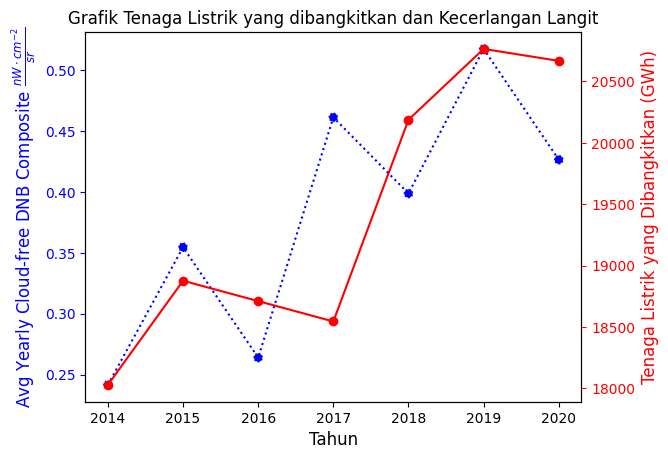

In [ ]:
fig,ax = plt.subplots()
plt.title("Grafik Tenaga Listrik yang dibangkitkan dan Kecerlangan Langit")

#add first line to plot
ax.plot(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
ax.scatter(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
#add x-axis label
ax.set_xlabel('Tahun', fontsize=12)
#ax.legend()

#add y-axis label
ax.set_ylabel(r'Avg Yearly Cloud-free DNB Composite $\frac{nW \cdot cm^{-2}}{sr}$', color='b', fontsize=12)
#ax.tick_params(axis='x', colors="b")
ax.tick_params(axis='y', colors="b")

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(ipm.Tahun, ipm.GWh, color='r', label='IPM')
ax2.scatter(ipm.Tahun, ipm.GWh, color='r', label='IPM')
#add second y-axis label
ax2.set_ylabel('Tenaga Listrik yang Dibangkitkan (GWh)', color='r', fontsize=12)
ax2.tick_params(axis='x', colors="r")
ax2.tick_params(axis='y', colors="r")

###Plot Kecerlangan Langit Tahunan Vs Persen Rumah Tangga menggunakan sumber penerangan dari Listrik Sumatra Utara

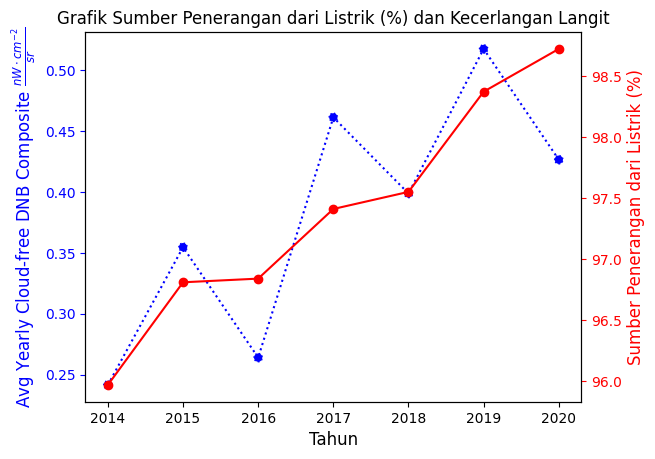

In [ ]:
fig,ax = plt.subplots()
plt.title("Grafik Sumber Penerangan dari Listrik (%) dan Kecerlangan Langit")

#add first line to plot
ax.plot(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
ax.scatter(dt, avgF, linestyle=':', color='b', label='Avg Monthly Cloud-free DNB Composite')
#add x-axis label
ax.set_xlabel('Tahun', fontsize=12)
#ax.legend()

#add y-axis label
ax.set_ylabel(r'Avg Yearly Cloud-free DNB Composite $\frac{nW \cdot cm^{-2}}{sr}$', color='b', fontsize=12)
#ax.tick_params(axis='x', colors="b")
ax.tick_params(axis='y', colors="b")

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(ipm.Tahun, ipm.persen, color='r', label='IPM')
ax2.scatter(ipm.Tahun, ipm.persen, color='r', label='IPM')
#add second y-axis label
ax2.set_ylabel('Sumber Penerangan dari Listrik (%)', color='r', fontsize=12)
ax2.tick_params(axis='x', colors="r")
ax2.tick_params(axis='y', colors="r")
#ax2.legend()


##Statistika : Perhitungan korelasi antara kecerlangan langit dengan data-data penunjang

###Rerata dan Standar Deviasi Nilai Kecerlangan Langit Sumatra Utara

In [ ]:
from numpy import mean
from numpy import std


print('data1: mean=%.3f stdv=%.3f' % (mean(avgF), std(avgF)))

data1: mean=0.381 stdv=0.093


In [ ]:
from numpy import cov

covarianceipm = cov(avgF, ipm.IPM)
covariancegwh = cov(avgF, ipm.GWh)
covarianceelrt = cov(avgF, ipm.persen)

In [ ]:
ipm.interpolate()

,Tahun,IPM,GWh,persen
0,2014,68.87,18028.30,95.97
1,2015,69.51,18876.59,96.81
2,2016,70.00,18710.79,96.84
3,2017,70.57,18544.99,97.41
4,2018,71.18,20188.10,97.55
5,2019,71.74,20764.57,98.37
6,2020,71.77,20667.17,98.72


###Korelasi Pearson Kecerlangan Langit dengan data-data penunjang

In [ ]:
from scipy.stats import pearsonr
corripm, _ = pearsonr(avgF, ipm.IPM)
print('Pearsons correlation antara Kecerlangan Langit dengan IPM : %.3f' % corripm)

corrgwh, _ = pearsonr(avgF, ipm.GWh)
print('Pearsons correlation antara Kecerlangan Langit dengan Tenaga Listrik yang Dibangkitkan : %.3f' % corrgwh)

correl, _ = pearsonr(avgF, ipm.persen)
print('Pearsons correlation antara Kecerlangan Langit dengan Sumber Penerangan dari Listrik: %.3f' % correl)

Pearsons correlation antara Kecerlangan Langit dengan IPM : 0.821
Pearsons correlation antara Kecerlangan Langit dengan Tenaga Listrik yang Dibangkitkan : 0.703
Pearsons correlation antara Kecerlangan Langit dengan Sumber Penerangan dari Listrik: 0.827


###Tabel Korelasi Pearson

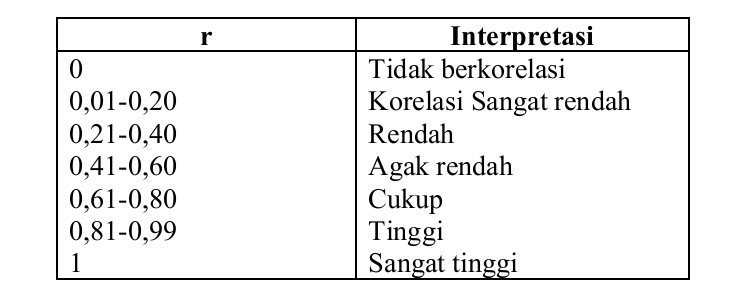

Dari tabel korelasi Pearson, **korelasi Kecerlangan Langit dengan IPM** dan **Kecerlangan Langit dengan Rumah Tangga dengan Sumber Penerangan dari Listrik sangat tinggi**, sedangkan **Kecerlangan Langit dengan Tenaga Listrik yang dibangkitkan** diinterpretasikan **cukup** (pada sumber lain diinterpretasikan **berkorelasi tinggi**) . Menurut saya, hal ini dikarenakan dilakukannya interpoladi data pada tahun  2016 yang kekosongan data pada Tenaga Listrik yang dibangkitkan.